<a href="https://colab.research.google.com/github/Hawar-Dzaee/Covid/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content
### Part I
- Objective.
- Fetching Data.
- Data Integrity.
- Common Features across selected DataFrames.
    - Concatenation of Datasets.
- Data Cleaning & EDA.
    - Human Errors.
    - Null Values.
        - First approach.
        - Second approach.
        - Third approach.
    - Correlation.
- Feature Engineering.
- More Featuring Engineering.
- Why I am not worried about multicollinearity.

### Part II
- Naive Forecaster : Baseline.
- ARIMA Model.
- ML (LSTM) Model

### Part III
- Future Work



In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Objective
Our goal is to uncover predictive insights within our dataset to efficiently allocate resources such as staff and medical supplies across hospitals and the broader health sector, based on anticipated needs.







# Fetching Data

Due to GitHub file size limits, the data are separated into multiple datasets, organized by [year, semi-annual, or quarter].

In [4]:
df_2020    = pd.read_csv('global_covid_metrics2020.csv')
df_2021_H1 = pd.read_csv('global_covid_metrics2021_H1.csv')
df_2021_H2 = pd.read_csv('global_covid_metrics2021_H2.csv')
df_2022_H1 = pd.read_csv('global_covid_metrics2022_H1.csv')
df_2022_H2 = pd.read_csv('global_covid_metrics2022_H2.csv')
df_2023_H1 = pd.read_csv('global_covid_metrics2023_H1.csv')
df_2023_H2 = pd.read_csv('global_covid_metrics2023_H2.csv')
df_2024_Q1 = pd.read_csv('global_covid_metrics2024_Q1.csv')
df_2024_Q2 = pd.read_csv('global_covid_metrics2024_Q2.csv')

In [5]:
dfs = [df_2020,
       df_2021_H1,
       df_2021_H2,
       df_2022_H1,
       df_2022_H2,
       df_2023_H1,
       df_2023_H2,
       df_2024_Q1,
       df_2024_Q2
       ]

df_names = ['df_2020',
            'df_2021_H1',
            'df_2021_H2',
            'df_2022_H1',
            'df_2022_H2',
            'df_2023_H1',
            'df_2023_H2',
            'df_2024_Q1',
            'df_2024_Q2'
            ]

# Data Integrity

verifying the integrity of datasets by checking if the time data is monotonically increasing. This ensures that the timestamps follow the correct chronological order.

In [6]:
for i in dfs:
  i['Date'] = pd.to_datetime(i['Date'])

In [7]:
for name,df in zip(df_names,dfs):
  if df['Date'].is_monotonic_increasing:
    print(f'{name:<10}: Data is monotonically increasing ',end=' ')
    print(df['Date'].min(),df['Date'].max())
  else :
    print(f'{name:<10}: Not consistent')

df_2020   : Data is monotonically increasing  2020-01-12 00:00:00 2020-12-31 00:00:00
df_2021_H1: Data is monotonically increasing  2021-01-01 00:00:00 2021-06-30 00:00:00
df_2021_H2: Data is monotonically increasing  2021-07-01 00:00:00 2021-12-31 00:00:00
df_2022_H1: Data is monotonically increasing  2022-01-01 00:00:00 2022-06-29 00:00:00
df_2022_H2: Data is monotonically increasing  2022-07-01 00:00:00 2022-12-31 00:00:00
df_2023_H1: Data is monotonically increasing  2023-01-01 00:00:00 2023-06-28 00:00:00
df_2023_H2: Data is monotonically increasing  2023-01-01 00:00:00 2023-10-25 00:00:00
df_2024_Q1: Not consistent
df_2024_Q2: Not consistent


There are two issues with the above datasets.\
First : 2023_H1 overlaps with 2023_H2, and 2023_H2 has a longer time frame, so 2023_H1 will be discarded.\
Second : Why aren't df_2024_Q1 and df_2024_Q2 included? This is because they are on a weekly timeframe, which is inconsistent with the daily timeframe. While it is possible to aggregate weekly data with daily data, this approach is not recommended due to the spikes that occur every seven days. These spikes can confuse the models. In summary, combining weekly data with daily data is avoided to preserve both the predictive ability and interpretability of the model.

In [8]:
dfs = [df_2020,
       df_2021_H1,
       df_2021_H2,
       df_2022_H1,
       df_2022_H2,
       df_2023_H2,
       ]

df_names = ['df_2020',
            'df_2021_H1',
            'df_2021_H2',
            'df_2022_H1',
            'df_2022_H2',
            'df_2023_H2',
            ]

# Common Features across selected df(s)

In [9]:
common_columns = set.intersection(*[set(df.columns) for df in dfs])
print(len(common_columns))
common_columns

19


{'Case_Change_7_Day_Rolling_Average',
 'Confirmed Cases',
 'Confirmed Deaths',
 'Country',
 'Date',
 'Death_Change_7_Day_Rolling_Average',
 'Income',
 'New Cases',
 'New Deaths',
 'Population',
 'Region',
 'cpm',
 'cpm_income',
 'cpm_region',
 'dpm',
 'dpm_income',
 'dpm_region',
 'new_cases_per_million',
 'new_deaths_per_million'}

Different models can be built, leveraging non-overlapping features. However, this wasn't undertaken due to time constraints.

In [10]:
# non-overlapping features between df_2020 and df_2021_H1
[i for i in df_2020.columns if i not in df_2021_H1.columns]

['new_cases_per_million_income',
 'new_deaths_per_million_income',
 'new_cases_per_million_region',
 'new_deaths_per_million_region']

### Concatenation of datasets

In [11]:
def concat_matching_columns_multiple(dataframes):
    """
    Concatenate multiple DataFrames, keeping only the columns that are present in all.

    Parameters:
    dataframes (list): A list of pandas DataFrames

    Returns:
    pd.DataFrame: A new DataFrame with rows from all input DataFrames,
                  but only columns present in all
    """
    common_columns = set.intersection(*[set(df.columns) for df in dataframes])
    subsetted_dfs = [df[list(common_columns)] for df in dataframes]
    result = pd.concat(subsetted_dfs, axis=0, ignore_index=True)

    return result

In [12]:
df = concat_matching_columns_multiple(dfs)
df

,dpm_region,Region,new_deaths_per_million,cpm_income,New Cases,Confirmed Deaths,Country,Income,cpm_region,Death_Change_7_Day_Rolling_Average,Date,Population,Case_Change_7_Day_Rolling_Average,new_cases_per_million,dpm,Confirmed Cases,New Deaths,cpm,dpm_income
0,0.000000,Eastern Mediterranean Region,NaN,0.000000,0,0,Afghanistan,Low income,0.000000,NaN,2020-01-12,38928341.0,NaN,NaN,0.000000,0,0,0.000000,0.000000
1,0.000000,European Region,NaN,0.015444,0,0,Albania,Upper middle income,0.000000,NaN,2020-01-12,2877800.0,NaN,NaN,0.000000,0,0,0.000000,0.000377
2,0.000000,African Region,NaN,0.000000,0,0,Algeria,Lower middle income,0.000000,NaN,2020-01-12,43851043.0,NaN,NaN,0.000000,0,0,0.000000,0.000000
3,NaN,NaN,NaN,0.015444,0,0,American Samoa,Upper middle income,NaN,NaN,2020-01-12,55197.0,NaN,NaN,0.000000,0,0,0.000000,0.000377
4,0.000000,European Region,NaN,0.000000,0,0,Andorra,High income,0.000000,NaN,2020-01-12,77265.0,NaN,NaN,0.000000,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317078,217.030126,Western Pacific Region,0.0,27039.747684,0,43206,Vietnam,Lower middle income,107778.968951,0.0,2023-10-25,97468029.0,0.0,0.0,443.283818,11624000,0,119259.618967,349.532859
317079,217.030126,Western Pacific Region,0.0,NaN,0,8,Wallis & Futuna,NaN,107778.968951,0.0,2023-10-25,11627.0,0.0,0.0,688.053668,3550,0,305323.815258,NaN
317080,461.728512,Eastern Mediterranean Region,0.0,2689.874496,0,2159,Yemen,Low income,30730.899236,0.0,2023-10-25,32981641.0,0.0,0.0,65.460660,11945,0,362.171185,60.504968
317081,150.898201,African Region,0.0,27039.747684,0,4069,Zambia,Lower middle income,8216.853157,0.0,2023-10-25,19473125.0,0.0,0.0,208.954649,349287,0,17936.874539,349.532859


In [13]:
df['Date'].is_monotonic_increasing # Checking the integrity of the concatenated dataset

True

# Data Cleaning & EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317083 entries, 0 to 317082
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   dpm_region                          274637 non-null  float64       
 1   Region                              274637 non-null  object        
 2   new_deaths_per_million              313151 non-null  float64       
 3   cpm_income                          292358 non-null  float64       
 4   New Cases                           317083 non-null  int64         
 5   Confirmed Deaths                    317083 non-null  int64         
 6   Country                             317083 non-null  object        
 7   Income                              292358 non-null  object        
 8   cpm_region                          274637 non-null  float64       
 9   Death_Change_7_Day_Rolling_Average  315733 non-null  float64       
 10  Date    

In [15]:
df.describe()

,dpm_region,new_deaths_per_million,cpm_income,New Cases,Confirmed Deaths,cpm_region,Death_Change_7_Day_Rolling_Average,Date,Population,Case_Change_7_Day_Rolling_Average,new_cases_per_million,dpm,Confirmed Cases,New Deaths,cpm,dpm_income
count,274637.000000,313151.000000,292358.000000,3.170830e+05,3.170830e+05,274637.000000,315733.000000,317083,3.145010e+05,3.157330e+05,313151.000000,314501.000000,3.170830e+05,317083.000000,314501.000000,292358.000000
mean,892.689589,0.934488,72713.767949,2.211271e+03,1.890056e+04,72881.919511,21.966473,2021-12-10 08:04:36.480290560,3.427476e+07,2.253010e+03,148.938855,763.757904,1.571232e+06,21.834655,97067.806194,748.394113
min,0.000000,-180.575939,0.000000,-6.507900e+04,0.000000e+00,0.000000,0.000000,2020-01-12 00:00:00,5.110000e+02,0.000000e+00,-571.468322,0.000000,0.000000e+00,-3520.000000,0.000000,0.000000
25%,120.189840,0.000000,3226.212001,0.000000e+00,3.500000e+01,4594.079520,0.000000,2020-12-29 00:00:00,4.374830e+05,2.857143e-01,0.000000,17.981077,4.532000e+03,0.000000,1541.224008,99.795604
50%,265.138019,0.000000,27022.882771,1.000000e+00,5.910000e+02,26817.362174,0.142857,2021-12-15 00:00:00,5.459643e+06,2.142857e+01,4.250418,216.147184,4.490000e+04,0.000000,20770.139793,398.631442
75%,2012.588452,0.533619,81254.917384,2.240000e+02,6.437000e+03,107623.485078,3.571429,2022-11-23 00:00:00,2.141325e+07,3.584286e+02,78.898291,1149.083092,4.866590e+05,2.000000,123737.313837,1120.224110
max,2893.589909,144.167370,342131.166314,2.165484e+06,1.136920e+06,297236.107159,4190.000000,2023-10-25 00:00:00,1.471287e+09,3.520697e+06,60402.684564,6575.734920,1.034368e+08,11447.000000,731871.388354,2341.410295
std,1028.420253,2.956178,106613.270479,1.675912e+04,7.762491e+04,94933.767443,127.081432,NaN,1.382757e+08,1.843007e+04,632.157489,1075.093548,6.974887e+06,138.733234,150508.049821,748.962646


From df.describe(), we immediately notice negative values in the min row, which, after a careful reading of the provided README.md file for the datasets, does not make any sense. These must be human errors, and we need to address them.

### Human Errors

In [16]:
for i in df.columns:
  if (df[i].dtype =='float64') or (df[i].dtype=='int64'):
    if (df[i]<0).any():
      print(f'{i:<22} :Has {len(df[df[i]<0])} values below zero')

new_deaths_per_million :Has 11 values below zero
New Cases              :Has 12 values below zero
new_cases_per_million  :Has 12 values below zero
New Deaths             :Has 11 values below zero


In [17]:
df[['Date','Country','New Deaths','new_deaths_per_million','Population']][df['new_deaths_per_million']==df['new_deaths_per_million'].min()]


,Date,Country,New Deaths,new_deaths_per_million,Population
267092,2023-03-28,Chile,-3520,-180.575939,19493184.0


One might think it's negative because of a reduction in the population, but that is not the case, as shown in plots below.

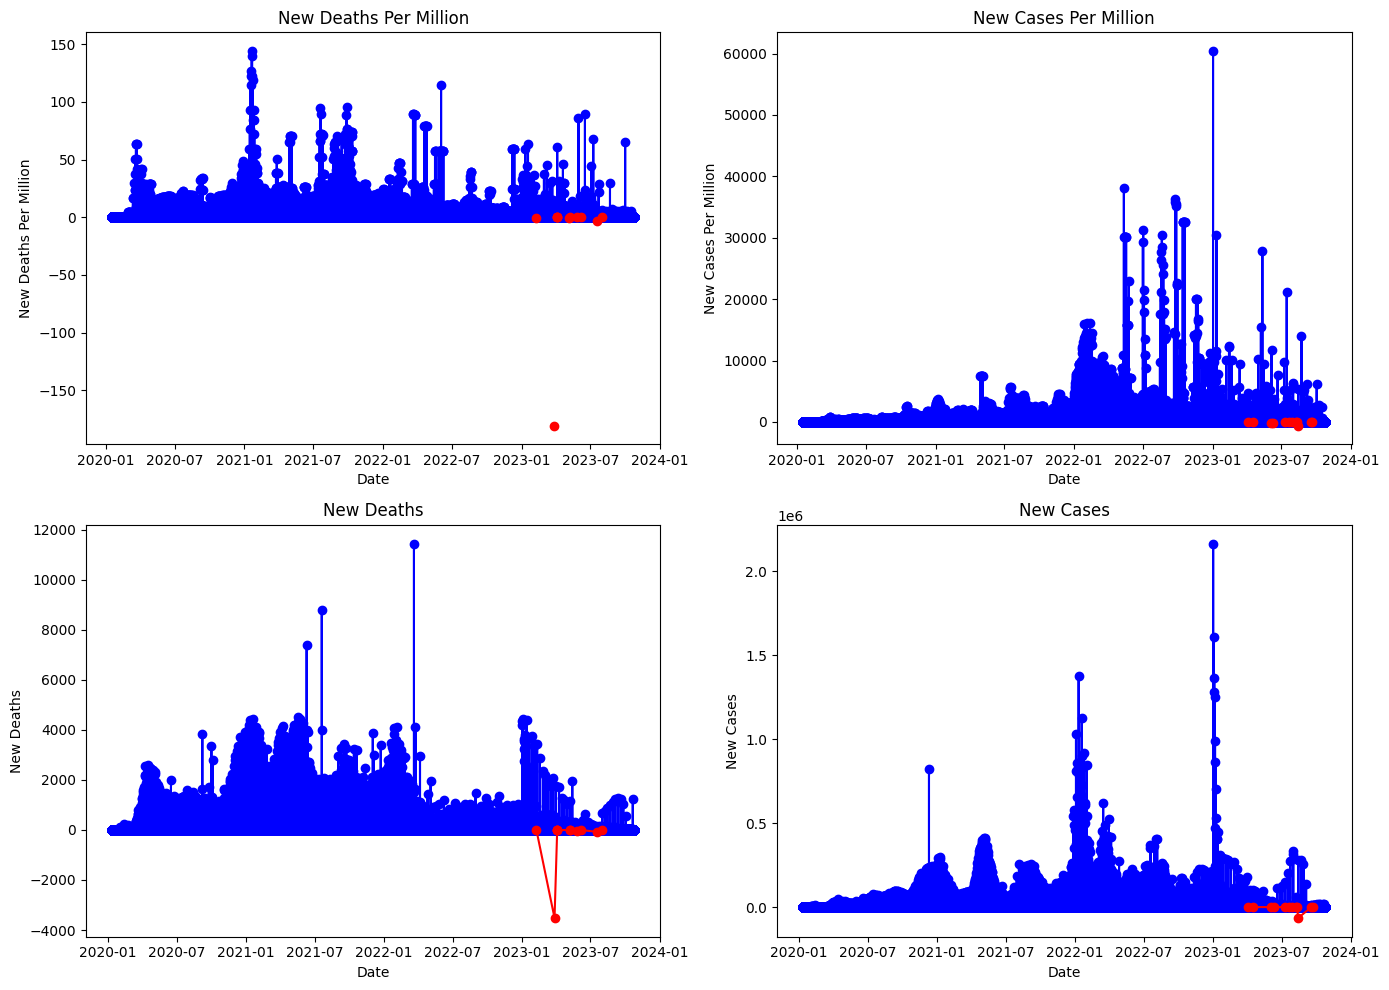

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def plot_with_color(ax, x, y, condition, color_above, color_below):
    ax.plot(x[condition], y[condition], color=color_above, marker='o')
    ax.plot(x[~condition], y[~condition], color=color_below, marker='o')

condition1 = df['new_deaths_per_million'] >= 0.0
plot_with_color(axs[0, 0], df['Date'], df['new_deaths_per_million'], condition1, 'blue', 'red')
axs[0, 0].set_title('New Deaths Per Million')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('New Deaths Per Million')

condition2 = df['new_cases_per_million'] >= 0.0
plot_with_color(axs[0, 1], df['Date'], df['new_cases_per_million'], condition2, 'blue', 'red')
axs[0, 1].set_title('New Cases Per Million')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('New Cases Per Million')

condition3 = df['New Deaths'] >= 0.0
plot_with_color(axs[1, 0], df['Date'], df['New Deaths'], condition3, 'blue', 'red')
axs[1, 0].set_title('New Deaths')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('New Deaths')

condition4 = df['New Cases'] >= 0.0
plot_with_color(axs[1, 1], df['Date'], df['New Cases'], condition4, 'blue', 'red')
axs[1, 1].set_title('New Cases')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('New Cases')

plt.tight_layout()
plt.show()


Red dots are below zero, while blue dots are above zero.

### Handling Human Errors

In [19]:
df['New Cases'] = df['New Cases'].abs()
df['new_cases_per_million'] = df['new_cases_per_million'].abs()
df['New Deaths'] = df['New Deaths'].abs()
#-----
df.loc[267092,'new_deaths_per_million'] = 0.000000
df['new_deaths_per_million'] = df['new_deaths_per_million'].abs()

Statistically, it doesn't make a significant difference whether we replace the negative values with their absolute values, the mean,median or mode over a certain period of time (2023-01 to 2023-09), or clip them to zero. It won't affect the standard deviation since the number of negative values is small, except for one value in 'New deaths per million', where taking abs() is not advisable. For instance, abs(-180) = 180, which still doesn't make sense

### Null Values

In [20]:
df.isna().sum()

dpm_region                            42446
Region                                42446
new_deaths_per_million                 3932
cpm_income                            24725
New Cases                                 0
Confirmed Deaths                          0
Country                                   0
Income                                24725
cpm_region                            42446
Death_Change_7_Day_Rolling_Average     1350
Date                                      0
Population                             2582
Case_Change_7_Day_Rolling_Average      1350
new_cases_per_million                  3932
dpm                                    2582
Confirmed Cases                           0
New Deaths                                0
cpm                                    2582
dpm_income                            24725
dtype: int64

In [21]:
df.isna().mean() * 100      # The percentage of null values per feature.

dpm_region                            13.386400
Region                                13.386400
new_deaths_per_million                 1.240054
cpm_income                             7.797643
New Cases                              0.000000
Confirmed Deaths                       0.000000
Country                                0.000000
Income                                 7.797643
cpm_region                            13.386400
Death_Change_7_Day_Rolling_Average     0.425756
Date                                   0.000000
Population                             0.814298
Case_Change_7_Day_Rolling_Average      0.425756
new_cases_per_million                  1.240054
dpm                                    0.814298
Confirmed Cases                        0.000000
New Deaths                             0.000000
cpm                                    0.814298
dpm_income                             7.797643
dtype: float64

Let's handle null values in the Income feature.\
But first, let's determine the proportion of null values.

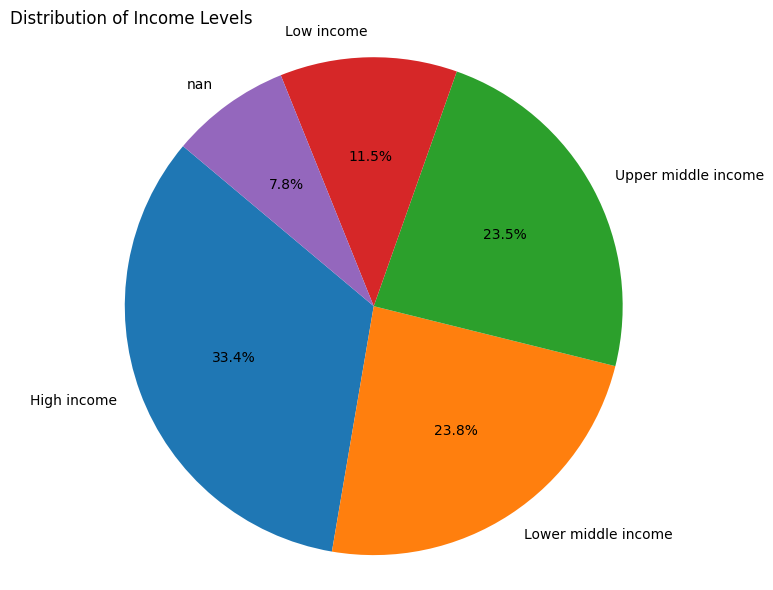

In [22]:
labels = df['Income'].value_counts(dropna=False).index
sizes = df['Income'].value_counts(dropna=False).values

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Income Levels',loc='left')
plt.axis('equal')
plt.tight_layout()
plt.show()


Filling with the mode is a bad idea because it will assign all NaN values (7.8%) to 'High income', thereby skewing the data.\
There are several approaches to handle NaN in Income feature.

#### First approach: fill the Income based on past year(s).
This method is applicable to only two countries [as shown below], as most countries' incomes are not registered.\
 A caveat is that a country's income might change during that period; however, the number of countries whose income changes in a span of three years is very small.

In [23]:
countries_with_nan_incomes = df['Country'][df['Income'].isna()].unique()

for country in countries_with_nan_incomes:
  if df.loc[df['Country']==country,'Income'].notnull().any():
    print(country,df.loc[df['Country']==country,'Income'].unique())

Turkey ['Upper middle income' nan]
St. Martin (French part) ['High income' nan]


In [24]:
df.loc[df['Country']=='Turkey','Income'] = 'Upper Middle Income'
df.loc[df['Country']=='St. Martin (French part)','Income'] = 'High income'


#### Second approach  [Best approach]

Find a dataset that completes the gap.

In [25]:
income_class_df = pd.read_csv('Class_Cleaned.Csv')
income_class_df.head()

,Unnamed: 0,Economy,Code,Region,Income group,Lending category
0,0,Afghanistan,AFG,South Asia,Low income,IDA
1,1,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD
2,2,Algeria,DZA,Middle East & North Africa,Upper middle income,IBRD
3,3,American Samoa,ASM,East Asia & Pacific,High income,NaN
4,4,Andorra,AND,Europe & Central Asia,High income,NaN


In [26]:
countries_with_nan_incomes = df['Country'][df['Income'].isna()].unique()
[i for i in income_class_df['Economy'].unique() if i in countries_with_nan_incomes]
# Unfortunately, there is only one country from which we learned the income group from the new dataset

[]

Although this is a best approach, but due to time constrains, I wasn't able to find a dataset that categorized countries income same as WHO

#### Third approach: random sampling

In [27]:
income_categories = list(df['Income'].value_counts().index)
df['Income'] = df['Income'].fillna(pd.Series(np.random.choice(income_categories, size=len(df), replace=True)))

In [28]:
df['Income'].value_counts(dropna=False)

Income
High income            111153
Lower middle income     80290
Upper middle income     78017
Low income              41345
Upper Middle Income      6278
Name: count, dtype: int64

#### Correlation

In [29]:
df_continous_values = df.select_dtypes(include=['float64', 'int64'])

corr = df_continous_values.corr()
corr.style.background_gradient(cmap='coolwarm')

,dpm_region,new_deaths_per_million,cpm_income,New Cases,Confirmed Deaths,cpm_region,Death_Change_7_Day_Rolling_Average,Population,Case_Change_7_Day_Rolling_Average,new_cases_per_million,dpm,Confirmed Cases,New Deaths,cpm,dpm_income
dpm_region,1.000000,0.099097,0.559489,0.048863,0.230248,0.877897,0.029543,-0.085951,0.043760,0.092005,0.694318,0.178710,0.026373,0.543670,0.645882
new_deaths_per_million,0.099097,1.000000,-0.021349,0.096622,0.045140,0.002938,0.255674,-0.024476,0.089082,0.238728,0.163852,0.008461,0.238524,0.018606,0.056040
cpm_income,0.559489,-0.021349,1.000000,0.053641,0.114699,0.691150,-0.034000,-0.064831,0.050328,0.132486,0.525435,0.222614,-0.031228,0.824003,0.943473
New Cases,0.048863,0.096622,0.053641,1.000000,0.305740,0.033409,0.525084,0.206242,0.896115,0.174089,0.074405,0.319785,0.552374,0.046368,0.078922
Confirmed Deaths,0.230248,0.045140,0.114699,0.305740,1.000000,0.177544,0.404383,0.375991,0.282590,0.004604,0.322984,0.812176,0.365050,0.092486,0.143868
cpm_region,0.877897,0.002938,0.691150,0.033409,0.177544,1.000000,-0.023741,-0.073738,0.032213,0.082102,0.701726,0.209329,-0.022253,0.709402,0.717273
Death_Change_7_Day_Rolling_Average,0.029543,0.255674,-0.034000,0.525084,0.404383,-0.023741,1.000000,0.271921,0.533147,0.044305,0.082380,0.292751,0.910098,-0.025497,-0.010063
Population,-0.085951,-0.024476,-0.064831,0.206242,0.375991,-0.073738,0.271921,1.000000,0.205562,-0.032827,-0.047909,0.442957,0.246290,-0.083747,-0.066762
Case_Change_7_Day_Rolling_Average,0.043760,0.089082,0.050328,0.896115,0.282590,0.032213,0.533147,0.205562,1.000000,0.155128,0.067500,0.318519,0.507172,0.043723,0.073155
new_cases_per_million,0.092005,0.238728,0.132486,0.174089,0.004604,0.082102,0.044305,-0.032827,0.155128,1.000000,0.096308,0.023220,0.044316,0.176291,0.202218


we want to remove features that are highly correlated with each other.
such as [feature : Death_change_7_days_Rolling_Average , feature: New Deaths]\
we want to keep features that are higly correlated with the target variable.such as [feature : Case_change_7_days_Rolling_Average , Target: New Cases]

High correlation = [-1 to -0.8 , 0.8 to 1]

# Feature Engineering

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

In [31]:
df_for_tree = df.copy()

df_for_tree = df_for_tree[['cpm_income',	'dpm_region','Income']]
df_for_tree.dropna(inplace=True)

In [32]:
X  = df_for_tree[['cpm_income',	'dpm_region']]
y = df_for_tree['Income']

print(X.shape)
print(y.shape)

(266342, 2)
(266342,)


In [33]:
y = LabelEncoder().fit_transform(y)

In [34]:
tree_clf = DecisionTreeClassifier(max_depth=3,random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

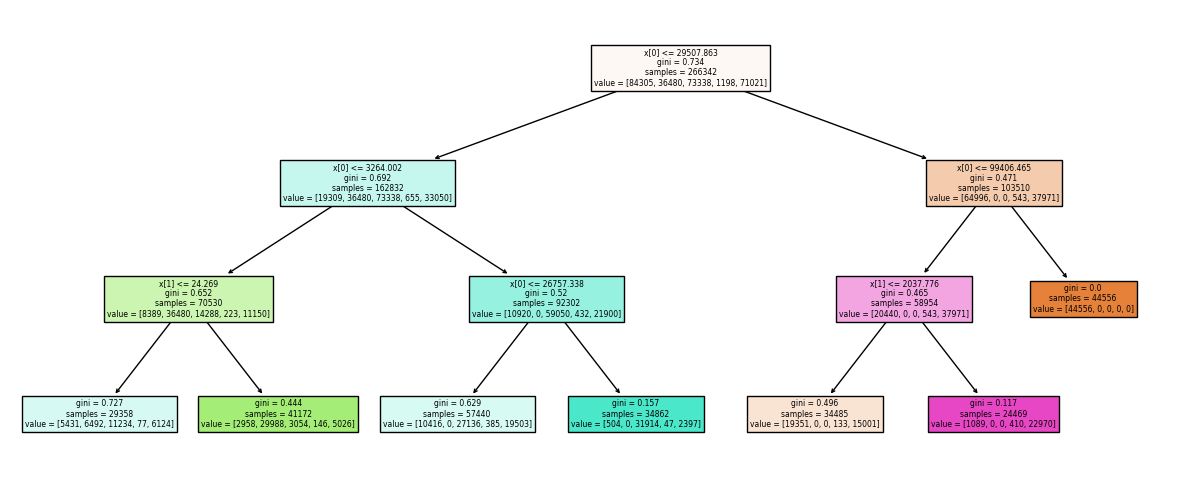

In [35]:
plt.figure(figsize=(15, 6))
plot_tree(tree_clf,filled=True)
plt.show()


In [36]:
tree_clf.feature_importances_

array([0.85332103, 0.14667897])

it seems like we did a good job finding a relevant feature for Income, using cpm_income.
Note: The selected max depth is purley based on the fact that deeper level might be harder to visualize,(but most certainly will yield a better result).

# More Feature Engineering
- It's important to create a feature that reflects the ratio of New Cases/New Deaths to population. This ratio provides a clearer indication of how a country is managing the outbreak, compared to examining New Cases or New Deaths numbers alone, which can be misleading.
- Fetching additional features such as quarantine measures might provide predictive power for outbreak rates.
- Another method to consider for feature engineering is Principal Component Analysis (PCA), which reduces the number of features while retaining those that explain high variance. This approach is particularly useful when dealing with a large number of features.

# Why I am not worried about multicollinearity

- When using Univariate Time Series Models: By definition, you have only one feature.

- When using Multivariate Models: Introducing regularization can mitigate multicollinearity. It's better to overfit and then adjust with regularization than to underfit initially, especially with a small dataset and when computational power isn't a constraint.

# Naive Forecaster: Serving as a baseline

In [37]:
df_series = df.copy()
df_series = df_series[['Date','New Cases']] #.set_index('Date')
df_series

,Date,New Cases
0,2020-01-12,0
1,2020-01-12,0
2,2020-01-12,0
3,2020-01-12,0
4,2020-01-12,0
...,...,...
317078,2023-10-25,0
317079,2023-10-25,0
317080,2023-10-25,0
317081,2023-10-25,0


In [38]:
df_series = df_series['New Cases'].groupby(df['Date']).sum()

In [39]:
diff_7 = df_series.shift(7)


<Axes: title={'center': 'New cases lag 7 days'}, xlabel='Date'>

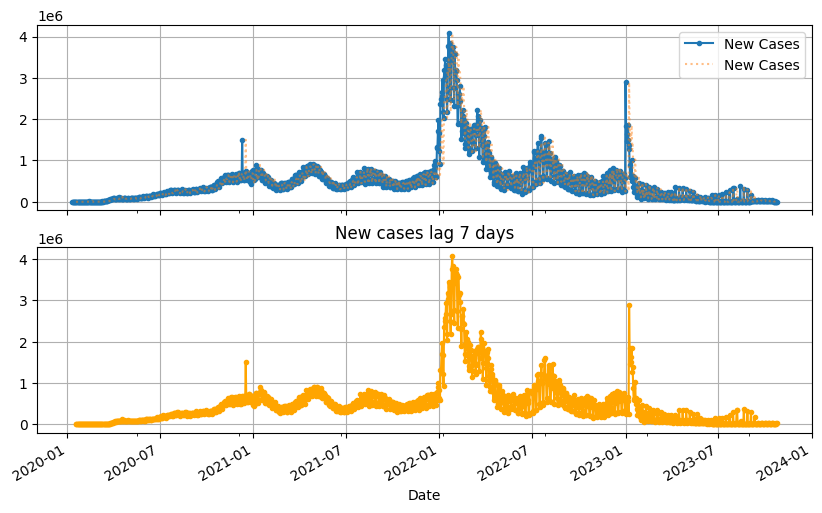

In [40]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=(10,6))

df_series.plot(ax = axs[0],legend=True,marker='.') # orininal time series
df_series.shift(7).plot(ax=axs[0],grid=True,legend=True,linestyle=':',alpha = 0.5)
diff_7.plot(ax=axs[1],grid=True,title = 'New cases lag 7 days',marker='.',color='orange')

In [41]:
(df_series-diff_7).abs().mean()

86441.62036363636

In [42]:
len(df_series)
len(diff_7)

1382

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [44]:
mean_absolute_error(df_series[7:],diff_7[7:])
mean_squared_error(df_series[7:],diff_7[7:])    # strongly penalizing large errors.
r2_score(df_series[7:],diff_7[7:])

0.8793523136480761

# Univariate Time Series Model.

In [45]:
time_series_data = df[['Date','New Cases']]
time_series_data

,Date,New Cases
0,2020-01-12,0
1,2020-01-12,0
2,2020-01-12,0
3,2020-01-12,0
4,2020-01-12,0
...,...,...
317078,2023-10-25,0
317079,2023-10-25,0
317080,2023-10-25,0
317081,2023-10-25,0


In [46]:
time_series_data = df.groupby(df['Date'].dt.date)['New Cases'].sum().reset_index()

In [47]:
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

In [48]:
print(len(train))
print(len(test))

1105
277


In [50]:
from statsmodels.tsa.arima.model import ARIMA

# Define the model
model = ARIMA(train['New Cases'], order=(50, 1, 0))  # Adjust order (p, d, q) based on your data



# Fit the model
model_fit = model.fit()


<ipython-input-51-a5f3c07cb747>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecasted New Cases'] = forecast


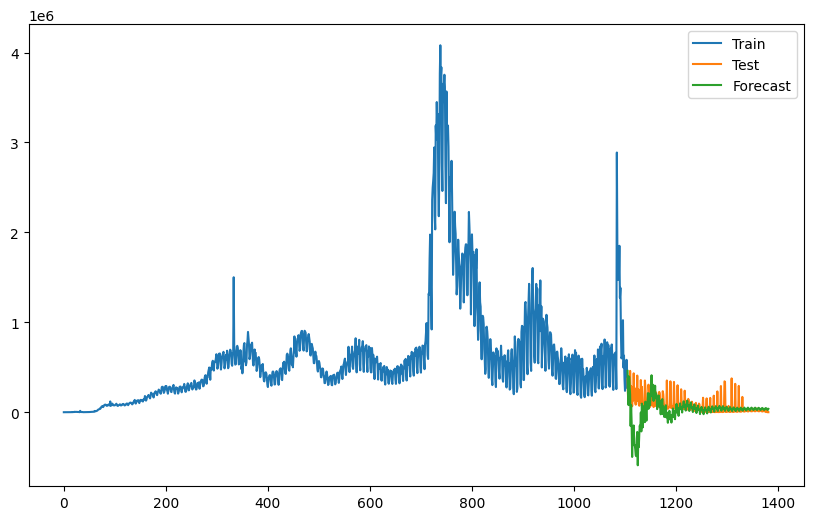

In [51]:
# Forecast the test set
forecast = model_fit.forecast(steps=len(test))
test['Forecasted New Cases'] = forecast

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['New Cases'], label='Train')
plt.plot(test.index, test['New Cases'], label='Test')
plt.plot(test.index, test['Forecasted New Cases'], label='Forecast')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(test['New Cases'], test['Forecasted New Cases'])
mse = mean_squared_error(test['New Cases'], test['Forecasted New Cases'])
rmse = np.sqrt(mse)

print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 98407.20643036667, RMSE: 166375.53997542727


Hyperparameter Search:

There are many hyperparameters that dictate the outcome of an ARIMA model. To find the best ones, several approaches can be used, such as grid search and random search. These are among the simpler methods.

# ML

In [53]:
df_ml = df.copy()
df_ml = df_ml[['Date','New Cases']]
df_ml

,Date,New Cases
0,2020-01-12,0
1,2020-01-12,0
2,2020-01-12,0
3,2020-01-12,0
4,2020-01-12,0
...,...,...
317078,2023-10-25,0
317079,2023-10-25,0
317080,2023-10-25,0
317081,2023-10-25,0


In [54]:
df_ml = df_ml.groupby('Date').sum().reset_index()
df_ml

,Date,New Cases
0,2020-01-12,41
1,2020-01-13,1
2,2020-01-14,0
3,2020-01-15,1
4,2020-01-16,0
...,...,...
1377,2023-10-21,2444
1378,2023-10-22,20440
1379,2023-10-23,0
1380,2023-10-24,0


In [55]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [56]:
scaler = MinMaxScaler()
df_ml['New Cases'] = scaler.fit_transform(df_ml[['New Cases']])
df_ml

,Date,New Cases
0,2020-01-12,1.004762e-05
1,2020-01-13,2.450639e-07
2,2020-01-14,0.000000e+00
3,2020-01-15,2.450639e-07
4,2020-01-16,0.000000e+00
...,...,...
1377,2023-10-21,5.989362e-04
1378,2023-10-22,5.009107e-03
1379,2023-10-23,0.000000e+00
1380,2023-10-24,0.000000e+00


In [57]:
train_size = int(len(df_ml) * 0.8)
val_size = int(len(df_ml) * 0.1)
test_size = len(df_ml) - train_size - val_size

print(f'Train size: {train_size}')
print(f'Val size: {val_size}')
print(f'Test size: {test_size}')

train_data = df_ml[:train_size]
val_data = df_ml[train_size:train_size + val_size]
test_data = df_ml[train_size + val_size:]

Train size: 1105
Val size: 138
Test size: 139


In [58]:
def create_sequences(data, window_size, prediction_size):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + prediction_size])
    return np.array(X), np.array(y)

In [59]:
window_size = 10
prediction_size = 2

X_train, y_train = create_sequences(train_data['New Cases'].values, window_size, prediction_size)
X_val, y_val = create_sequences(val_data['New Cases'].values, window_size, prediction_size)
X_test, y_test = create_sequences(test_data['New Cases'].values, window_size, prediction_size)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print('-------------------------------')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print('-------------------------------')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1094, 10)
y_train shape: (1094, 2)
-------------------------------
X_val shape: (127, 10)
y_val shape: (127, 2)
-------------------------------
X_test shape: (128, 10)
y_test shape: (128, 2)


Using 10 days to predict the next 2 dyas

In [60]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))    # (samples, time steps, features).
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (1094, 10, 1)
X_val shape: (127, 10, 1)
X_test shape: (128, 10, 1)


In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(prediction_size)
])

model.compile(optimizer='adam', loss='mae')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/20
35/35 [==============================] - 4s 27ms/step - loss: 0.0637 - val_loss: 0.0176
Epoch 2/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0358 - val_loss: 0.0169
Epoch 3/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0341 - val_loss: 0.0204
Epoch 4/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0334 - val_loss: 0.0170
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0172
Epoch 6/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0325 - val_loss: 0.0190
Epoch 7/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0318 - val_loss: 0.0158
Epoch 8/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0338 - val_loss: 0.0310
Epoch 9/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0325 - val_loss: 0.0159
Epoch 10/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0314 - val_loss: 0.0154
Epoch 11/20
35/35 

In [62]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

4/4 [==============================] - 0s 4ms/step - loss: 0.0110
Test Loss: 0.011003597639501095


In [63]:
predictions = model.predict(X_test)

print(f"Predictions: {predictions[0]}")
print(f"Actual:      { y_test[0]}")

4/4 [==============================] - 1s 3ms/step
Predictions: [0.00671525 0.00604332]
Actual:      [0.03945848 0.00065702]


# Future Work

- Data: The datasets are extremely messy. A search for better datasets or cross-validation with the current ones is needed.

- Better and More Features: With only one feature, the model's predictive power is very limited, especially for a complex problem like this. A multivariate approach is needed.

- Better Algorithms and Architectures: What I implemented here is by no means an exhaustive list of applicable algorithms for time series data. Architectures such as Transformers can be very powerful in this domain.

- Serving Model Endpoint on Streamlit: The model endpoint should be served so that the client can easily access it and make predictions. This can be done using the Python library Streamlit.



